In [1]:
from scipy import  stats
import statsmodels.api as sm  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.arima_model import ARMA

from statsmodels.stats.stattools import durbin_watson 
from statsmodels.graphics.api import qqplot

import sklearn.metrics
import itertools


In [ ]:
from scipy import  stats
import statsmodels.api as sm  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.arima_model import ARMA

from statsmodels.stats.stattools import durbin_watson 
from statsmodels.graphics.api import qqplot

import sklearn.metrics
import itertools


# 1.平稳性检验 单位根检验（ADF、DF、PP） 如果序列是平稳的，则不存在单位根， 否则就会存在单位根
from statsmodels.tsa.stattools import adfuller

adfuller(AdjustTc)

# 非平稳序列的处理

#1.差分
def stationarity(timeseries): 
    
    diff1 = timeseries.diff(1).dropna() 
    diff2 = diff1.diff(1) 
    
    diff1.plot(color = 'red',title='diff 1',figsize=(10,4))
    diff2.plot(color = 'black',title='diff 2',figsize=(10,4))

# 2.对数变换
ts_log = np.log(ts)

# 3.分解 trend（趋势部分） ， seasonal（季节性部分） 和residual (残留部分)
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose(timeseries):
    decomposition = seasonal_decompose(timeseries)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    Data = [timeseries,trend,seasonal,residual]
    color = ['red', 'black', 'orange','green']
    title = ["timeseries",'trend',"seasonal",'residual']

    # 画子图
    plt.figure(figsize = (12,10))
    for i in range(0,4):
        ax = plt.subplot(2,2,i+1)
        Data[i].plot(ax = ax,color = color[i])
        plt.title(title[i])
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
    return trend , seasonal, residual

trend , seasonal, residual = decompose(AdjustTc)

residual.dropna(inplace=True)
draw_trend(residual,12)
teststationarity(residual)

# 2.Ljung-Box检验检验时间序列是否存在自相关性，白噪声检验（纯随机性检验）, 白噪声序列，随机产生的序列，不具有时间上的相关性
from statsmodels.stats.diagnostic import acorr_ljungbox

p_value = acorr_ljungbox(AdjustTc, lags=1) 
print (p_value)

# 3.时间序列定阶
## 3.1 ACF和PACF定阶

fig = plt.figure(figsize=(12, 8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(AdjustTc,ax=ax1)

ax2=fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(AdjustTc,ax=ax2)

# 3.2调试最佳参数

p_value = []
q_value = []
aicList = []
bicList= []
hqicList = []

p_min = 0
q_min = 0
p_max = 20
q_max = 20


for p,q in itertools.product(range(p_min,p_max+1),range(q_min,q_max+1)):

    arma_model = ARMA(data_train1,(p,q))
    try:
        result = arma_model.fit(disp=-1, method='css')
    except:
        continue 
    bic = result.bic
    aicList.append(result.aic)
    bicList.append(result.bic)
    hqicList.append(result.hqic)
    p_value.append(p)
    q_value.append(q)
        
df = pd.DataFrame({'p':p_value,'q':q_value,'aic':aicList,'bic':bicList,'hqic':hqicList})

plt.figure(figsize=(15,6))
plt.plot(aicList,'r',label='aic value')
plt.plot(bicList,'b',label='bic value')
plt.plot(hqicList,'k',label='hqic value')
plt.legend(loc=0)

aic_min = df.loc[df.aic== df.aic.min(),:]
bic_min = df.loc[df.bic== df.bic.min(),:]
hq_min = df.loc[df.hqic== df.hqic.min(),:]

# 拟合效果
p_value = []
q_value = []
MSEList = []
MAEList= []
R2List = []

p_min = 0
q_min = 0
p_max = 20
q_max = 20

for p,q in itertools.product(range(p_min,p_max+1),range(q_min,q_max+1)):

    arma_model = ARMA(data_train1,(p,q))
    try:
        result = arma_model.fit(disp=-1, method='css')
    except:
        continue 
    pred = result.predict()
    pred_one = result.predict(start= "2019-01-01",end =" 2019-12-31", \
                      dynamic=True)

    data_test_result = data_test1['Adjust_Tc'].values
    pred_one_result = pred_one.values
 
    MSE = sklearn.metrics.mean_squared_error(data_test_result,pred_one_result)
    MAE = sklearn.metrics.mean_absolute_error(data_test_result,pred_one_result)
    R2 = sklearn.metrics.r2_score(data_test_result,pred_one_result)

    MSEList.append(MSE)
    MAEList.append(MAE)
    R2List.append(R2)
    p_value.append(p)
    q_value.append(q)

       
df = pd.DataFrame({'p':p_value,'q':q_value,'MSE':MSEList,'MAE':MAEList,'R2':R2List})

plt.figure(figsize=(15,6))
plt.plot(MSEList,'r',label='MSE')
plt.plot(MAEList,'b',label='MAE')
plt.plot(R2List,'k',label='R2')
plt.legend(loc=0) 
                  
MSE_min = df.loc[df.MSE== df.MSE.min(),:]
MAE_min = df.loc[df.MAE== df.MAE.min(),:]
R2_max = df.loc[df.R2== df.R2.max(),:]

# 4.模型残差检验
resid = result.resid
print(resid.describe())
resid.hist()
resid.plot(kind='kde')
### 使用qq图，检测是否符合正态分布
qqplot(resid,line='q',fit=True)
### D-W检验，检验自相关性
"""
检验一阶自相关性。因为自相关系数ρ的值介于-1和1之间，所以0≤DW≤４。
DW＝O＝＞ρ＝１　　 即存在正自相关性 
DW＝４＜＝＞ρ＝－１　即存在负自相关性 
DW＝２＜＝＞ρ＝０　　即不存在（一阶）自相关性 
当DW值显著的接近于O或４时，则存在自相关性，而接近于２时，则不存在（一阶）自相关性
"""
print('D-W检验值为{}'.format(durbin_watson(resid.values)))

from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test
# p_value = acorr_ljungbox(resid, lags=20) 
# print ("白噪声检验p_value为{}".format(p_value))

In [2]:
AdjustTc = pd.read_excel(r"C:\Users\13670\Desktop\待完成\006 时间序列模型\Tc\20201123Adjust_Tc.xlsx")

In [3]:
AdjustTc['Date'] = pd.to_datetime(AdjustTc['Date'])
AdjustTc = AdjustTc.set_index("Date")

<AxesSubplot:xlabel='Date'>

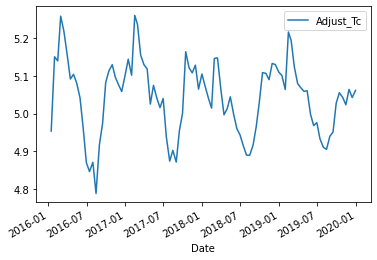

In [6]:
AdjustTc.plot()

In [6]:
# 1.平稳性检验 单位根检验（ADF、DF、PP） 如果序列是平稳的，则不存在单位根， 否则就会存在单位根
from statsmodels.tsa.stattools import adfuller

adfuller(AdjustTc)

(-4.938178090839658,
 2.9373303630934948e-05,
 10,
 85,
 {'1%': -3.5097356063504983,
  '5%': -2.8961947486260944,
  '10%': -2.5852576124567475},
 -254.49728002289112)

In [ ]:
# 非平稳序列的处理

#1.差分
def stationarity(timeseries): 
    
    diff1 = timeseries.diff(1).dropna() 
    diff2 = diff1.diff(1) 
    
    diff1.plot(color = 'red',title='diff 1',figsize=(10,4))
    diff2.plot(color = 'black',title='diff 2',figsize=(10,4))

# 2.对数变换
ts_log = np.log(ts)

# 3.分解 trend（趋势部分） ， seasonal（季节性部分） 和residual (残留部分)
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose(timeseries):
    decomposition = seasonal_decompose(timeseries)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    Data = [timeseries,trend,seasonal,residual]
    color = ['red', 'black', 'orange','green']
    title = ["timeseries",'trend',"seasonal",'residual']

    # 画子图
    plt.figure(figsize = (12,10))
    for i in range(0,4):
        ax = plt.subplot(2,2,i+1)
        Data[i].plot(ax = ax,color = color[i])
        plt.title(title[i])
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
    return trend , seasonal, residual

trend , seasonal, residual = decompose(AdjustTc)

residual.dropna(inplace=True)
draw_trend(residual,12)
teststationarity(residual)

In [9]:
# 2.Ljung-Box检验检验时间序列是否存在自相关性，白噪声检验（纯随机性检验）, 白噪声序列，随机产生的序列，不具有时间上的相关性
from statsmodels.stats.diagnostic import acorr_ljungbox

p_value = acorr_ljungbox(AdjustTc, lags=1) 
print (p_value)

# plt.plot(lb_test(data_train1)[1])

(array([64.75223109]), array([8.49333943e-16]))


C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


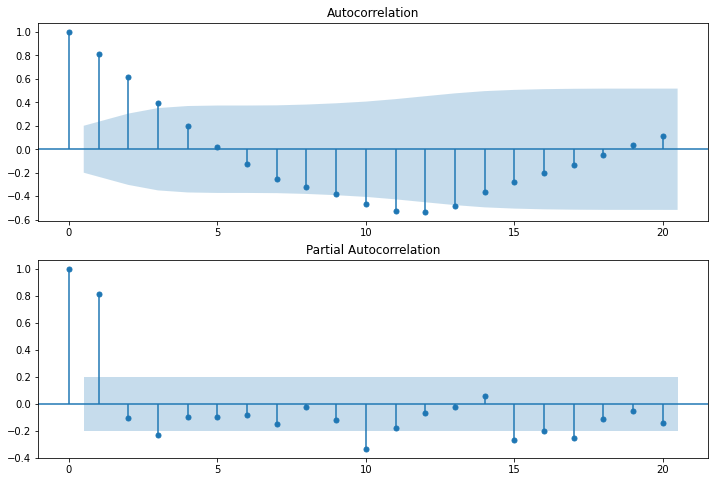

In [10]:
# 3.时间序列定阶
## 3.1 ACF和PACF定阶

fig = plt.figure(figsize=(12, 8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(AdjustTc,ax=ax1)

ax2=fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(AdjustTc,ax=ax2)

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

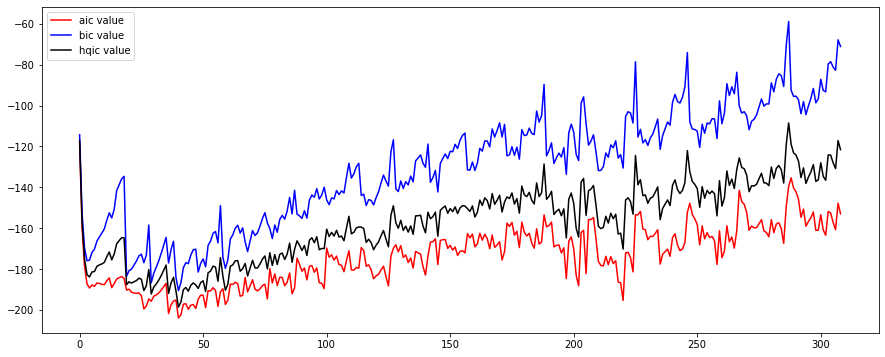

In [16]:
# 3.2调试最佳参数

p_value = []
q_value = []
aicList = []
bicList= []
hqicList = []

p_min = 0
q_min = 0
p_max = 20
q_max = 20


for p,q in itertools.product(range(p_min,p_max+1),range(q_min,q_max+1)):

    arma_model = ARMA(data_train1,(p,q))
    try:
        result = arma_model.fit(disp=-1, method='css')
    except:
        continue 
    bic = result.bic
    aicList.append(result.aic)
    bicList.append(result.bic)
    hqicList.append(result.hqic)
    p_value.append(p)
    q_value.append(q)
        
df = pd.DataFrame({'p':p_value,'q':q_value,'aic':aicList,'bic':bicList,'hqic':hqicList})

plt.figure(figsize=(15,6))
plt.plot(aicList,'r',label='aic value')
plt.plot(bicList,'b',label='bic value')
plt.plot(hqicList,'k',label='hqic value')
plt.legend(loc=0)

aic_min = df.loc[df.aic== df.aic.min(),:]
bic_min = df.loc[df.bic== df.bic.min(),:]
hq_min = df.loc[df.hqic== df.hqic.min(),:]

In [14]:
aic_min

,p,q,aic,bic,hqic
40,3,1,-204.00882,-190.604181,-198.690752


In [15]:
bic_min

,p,q,aic,bic,hqic
40,3,1,-204.00882,-190.604181,-198.690752


In [16]:
hq_min

,p,q,aic,bic,hqic
40,3,1,-204.00882,-190.604181,-198.690752


In [5]:
#AIC
AIC = sm.tsa.arma_order_select_ic(data_train1,\
    max_ar=5,max_ma=5,ic='aic')['aic_min_order']
#BIC
BIC = sm.tsa.arma_order_select_ic(data_train1,max_ar=5,\
       max_ma=5,ic='bic')['bic_min_order']
#HQIC
HQIC = sm.tsa.arma_order_select_ic(data_train1,max_ar=5,\
             max_ma=5,ic='hqic')['hqic_min_order']

print('the AIC is{},\nthe BIC is{}\n the HQIC is{}'.format(AIC,BIC,HQIC))

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\bas

the AIC is(2, 1),
the BIC is(2, 1)
 the HQIC is(2, 1)


C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [4]:
def Resampling(timeserise): 
    df = timeserise
    data = df['2016-1-1':'2019-01-01'] 
    test = df['2019-01-01':'2019-12-31']
    data_train = data.resample('SM').mean()  
    data_test = test.resample('SM').mean()
 
    return data_train,data_test

data_train1,data_test1 = Resampling(AdjustTc)

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning

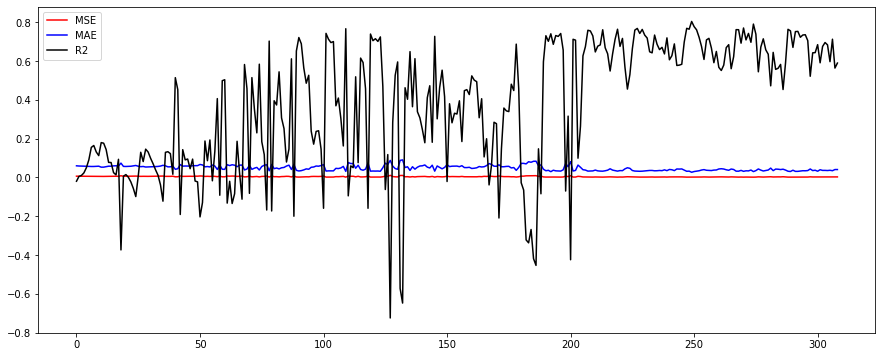

In [6]:
p_value = []
q_value = []
MSEList = []
MAEList= []
R2List = []

p_min = 0
q_min = 0
p_max = 20
q_max = 20

for p,q in itertools.product(range(p_min,p_max+1),range(q_min,q_max+1)):

    arma_model = ARMA(data_train1,(p,q))
    try:
        result = arma_model.fit(disp=-1, method='css')
    except:
        continue 
    pred = result.predict()
    pred_one = result.predict(start= "2019-01-01",end =" 2019-12-31", \
                      dynamic=True)

    data_test_result = data_test1['Adjust_Tc'].values
    pred_one_result = pred_one.values
 
    MSE = sklearn.metrics.mean_squared_error(data_test_result,pred_one_result)
    MAE = sklearn.metrics.mean_absolute_error(data_test_result,pred_one_result)
    R2 = sklearn.metrics.r2_score(data_test_result,pred_one_result)

    MSEList.append(MSE)
    MAEList.append(MAE)
    R2List.append(R2)
    p_value.append(p)
    q_value.append(q)

       
df = pd.DataFrame({'p':p_value,'q':q_value,'MSE':MSEList,'MAE':MAEList,'R2':R2List})

plt.figure(figsize=(15,6))
plt.plot(MSEList,'r',label='MSE')
plt.plot(MAEList,'b',label='MAE')
plt.plot(R2List,'k',label='R2')
plt.legend(loc=0) 
                  
MSE_min = df.loc[df.MSE== df.MSE.min(),:]
MAE_min = df.loc[df.MAE== df.MAE.min(),:]
R2_max = df.loc[df.R2== df.R2.max(),:]

In [7]:
MSE_min

,p,q,MSE,MAE,R2
249,18,2,0.001199,0.02653,0.803977


In [8]:
MAE_min

,p,q,MSE,MAE,R2
249,18,2,0.001199,0.02653,0.803977


In [9]:
R2_max

,p,q,MSE,MAE,R2
249,18,2,0.001199,0.02653,0.803977


In [ ]:
# 4.模型残差检验
# 残差假设，残差像白噪声，无自相关性，残差均值为0，此外，计算预测的置信区间还需要残差为正态分布且方差恒定

<AxesSubplot:xlabel='Date'>

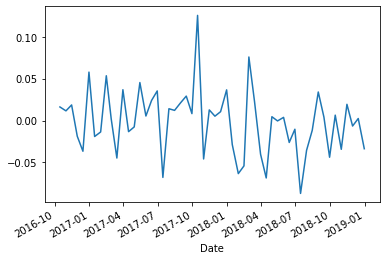

In [15]:
resid.plot()

In [8]:
resid = result.resid
print(resid.describe())

count    54.000000
mean     -0.001068
std       0.038512
min      -0.087092
25%      -0.028097
50%       0.003925
75%       0.019175
max       0.125613
dtype: float64


<AxesSubplot:ylabel='Density'>

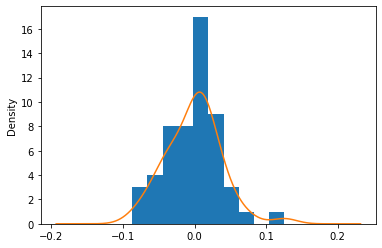

In [12]:
resid.hist()

resid.plot(kind='kde')

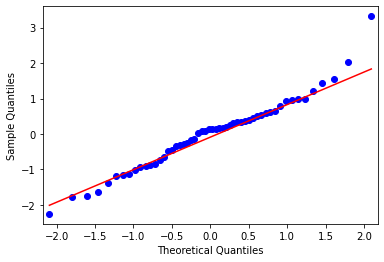

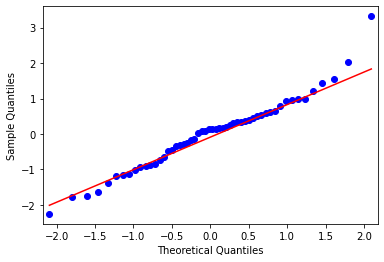

In [14]:
### 使用qq图，检测是否符合正态分布
qqplot(resid,line='q',fit=True)

In [16]:
### D-W检验，检验自相关性
"""
检验一阶自相关性。因为自相关系数ρ的值介于-1和1之间，所以0≤DW≤４。
DW＝O＝＞ρ＝１　　 即存在正自相关性 
DW＝４＜＝＞ρ＝－１　即存在负自相关性 
DW＝２＜＝＞ρ＝０　　即不存在（一阶）自相关性 
当DW值显著的接近于O或４时，则存在自相关性，而接近于２时，则不存在（一阶）自相关性
"""
print('D-W检验值为{}'.format(durbin_watson(resid.values)))

D-W检验值为2.106064466077164


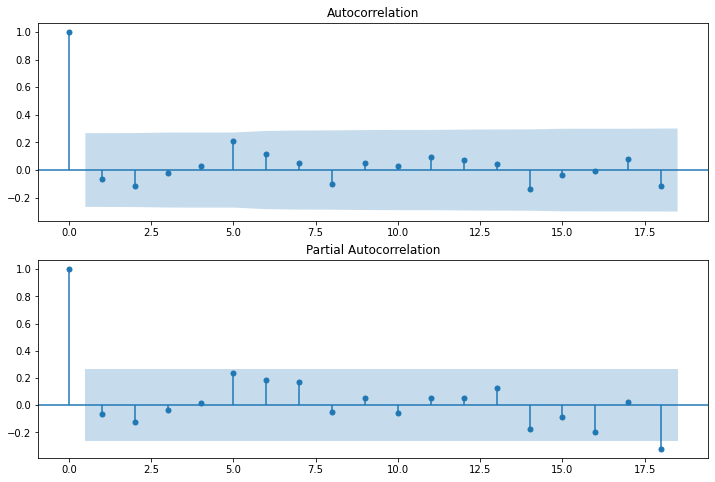

In [17]:
### ACF和PACF
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid,ax=ax2)

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:496: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


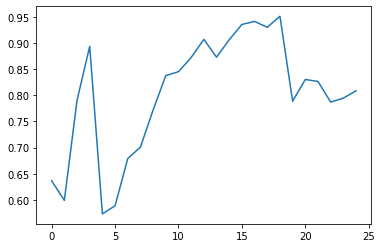

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test
# p_value = acorr_ljungbox(resid, lags=20) 
# print ("白噪声检验p_value为{}".format(p_value))
plt.plot(lb_test(resid)[1])

In [20]:
"""
prob值均大于0.05，残差序列不存在自相关性
"""
r,q,p = sm.tsa.acf(resid.values.squeeze(),qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table= pd.DataFrame(data, columns=[ 'lag','AC','Q','Prob(>Q)'])
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0  -0.062527   0.223068  0.636712
2.0  -0.117390   1.024455  0.599160
3.0  -0.018839   1.045498  0.790245
4.0   0.031177   1.104283  0.893592
5.0   0.210365   3.835362  0.573355
6.0   0.113954   4.653452  0.588964
7.0   0.054131   4.841982  0.679240
8.0  -0.101438   5.518416  0.700999
9.0   0.048016   5.673351  0.772113
10.0  0.027869   5.726730  0.837676
11.0  0.098037   6.402647  0.845194
12.0  0.071790   6.773722  0.872197
13.0  0.042207   6.905112  0.906975
14.0 -0.136020   8.303827  0.872904
15.0 -0.037598   8.413438  0.906140
16.0 -0.008959   8.419825  0.935374
17.0  0.081966   8.968924  0.941232
18.0 -0.113864  10.057984  0.929997
19.0  0.013526  10.073792  0.951102
20.0 -0.230063  14.781354  0.788779
21.0  0.027943  14.852903  0.830260
22.0  0.099213  15.783082  0.826504
23.0 -0.130347  17.440461  0.787093
24.0  0.085139  18.171122  0.794629
25.0 -0.074917  18.756383  0.808649
26.0 -0.002556  18.757089  0

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


In [ ]:
# 5.模型预测

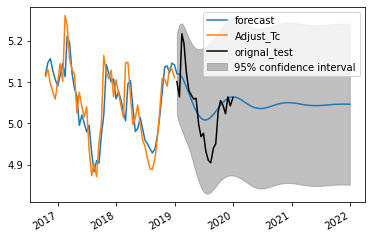

In [5]:
arma_model1 = ARMA(data_train1,(3,1))
result1 = arma_model1.fit(disp=-1, method='css')
fig = result1.plot_predict(start= "2016-10-15",end =" 2021-12-31")
plt.plot(data_test1,color = "black",label = "orignal_test")
plt.legend(loc = 0)

C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\13670\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


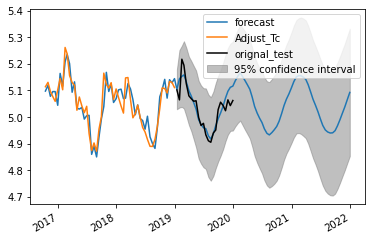

In [7]:
arma_model1 = ARMA(data_train1,(18,2))
result = arma_model1.fit(disp=-1, method='css')
fig = result1.plot_predict(start= "2016-10-15",end =" 2021-12-31")
plt.plot(data_test1,color = "black",label = "orignal_test")
plt.legend(loc = 0)